# Market Prediction

Elias Eskelinen, Vili Niemelä, Matti Aalto and Jarkko Komulainen

---

In this project, a model to predict the house-prices of the Philadelphia metropolitan areas in U.S. is implemented.

## Data onboarding

Initialize libraries

In [1]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

figs_dir = "./figures"
figs_dir = figs_dir if os.path.isdir(figs_dir) else ""

Fetch the data from the kaggle API (saved as a local file)

In [2]:
# Fetch the latest version of the dataset from kaggle
# Requires authentication
data_dir = kagglehub.competition_download('hull-tactical-market-prediction')
data_path = os.path.join(data_dir, "train.csv")

Load the data from the local file

In [3]:
data = pd.read_csv(data_path)
print(data.shape)
print(data.head())

(9021, 98)
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]


---

## Data visualization and exploratory analysis

The time-series dataset consists of 9021 samples with 98 variables. The variables are

- `date_id`: An identifier for a single trading day.

- `M*`: Market Dynamics/Technical features.

- `E*`: Macro Economic features.

- `I*`: Interest Rate features.

- `P*`: Price/Valuation features.

- `V*`: Volatility features.

- `S*`: Sentiment features.

- `MOM*`: Momentum features.

- `D*`: Dummy/Binary features.

- `forward_returns`: The returns from buying the S&P 500 and selling it a day later.

- `risk_free_rate`: The federal funds rate. 

- `market_forward_excess_returns`: Forward returns relative to expectations. Computed by subtracting the rolling five-year mean forward returns and winsorizing the result using a median absolute deviation (MAD) with a criterion of 4.


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        9021 non-null   int64  
 1   D1                             9021 non-null   int64  
 2   D2                             9021 non-null   int64  
 3   D3                             9021 non-null   int64  
 4   D4                             9021 non-null   int64  
 5   D5                             9021 non-null   int64  
 6   D6                             9021 non-null   int64  
 7   D7                             9021 non-null   int64  
 8   D8                             9021 non-null   int64  
 9   D9                             9021 non-null   int64  
 10  E1                             7237 non-null   float64
 11  E10                            8015 non-null   float64
 12  E11                            8015 non-null   f

There is plenty of missing data; most variables have over a thousand `null` values.

The predicted feature is `forward_returns`. Plotting the predicted variables over time

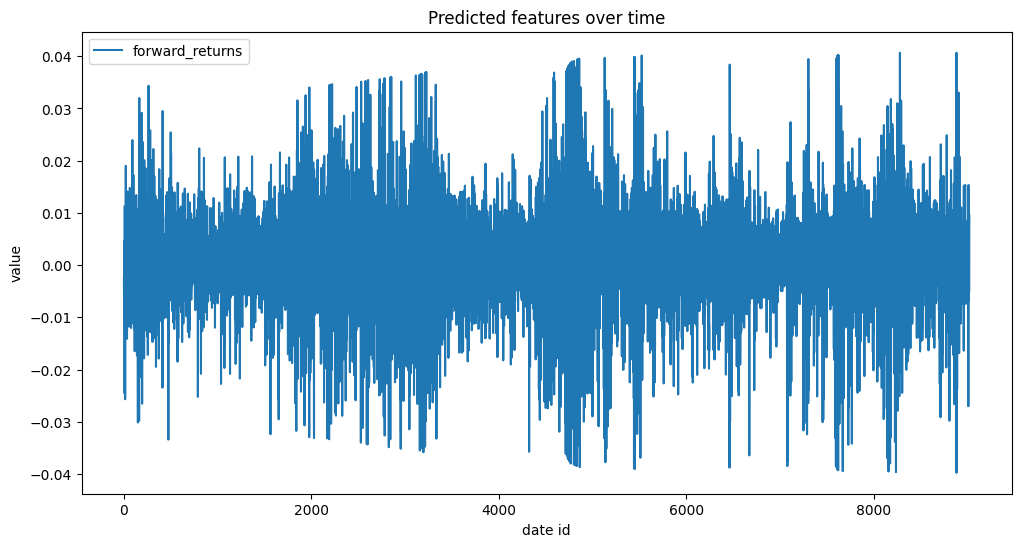

In [41]:
plt.figure(figsize=(12,6))
for f in ['forward_returns']:
    plt.plot(data['date_id'], data[f], label=f)
plt.title('Predicted features over time')
plt.legend(loc='upper left')
plt.xlabel("date id")
plt.ylabel("value")
if figs_dir: plt.savefig(os.path.join(figs_dir, "forward_returns.png"))
plt.show()

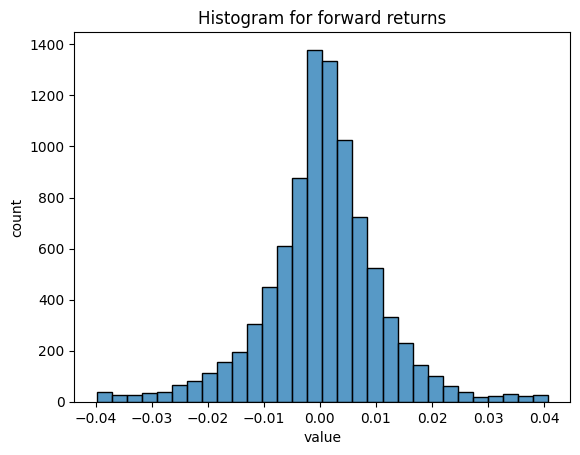

In [47]:
sns.histplot(data['forward_returns'], bins=30)
plt.title("Histogram for forward returns")
plt.xlabel("value")
plt.ylabel("count")
if figs_dir: plt.savefig(os.path.join(figs_dir, "forward_returns_hist.png"))
plt.show()

The correlation matrix of the data

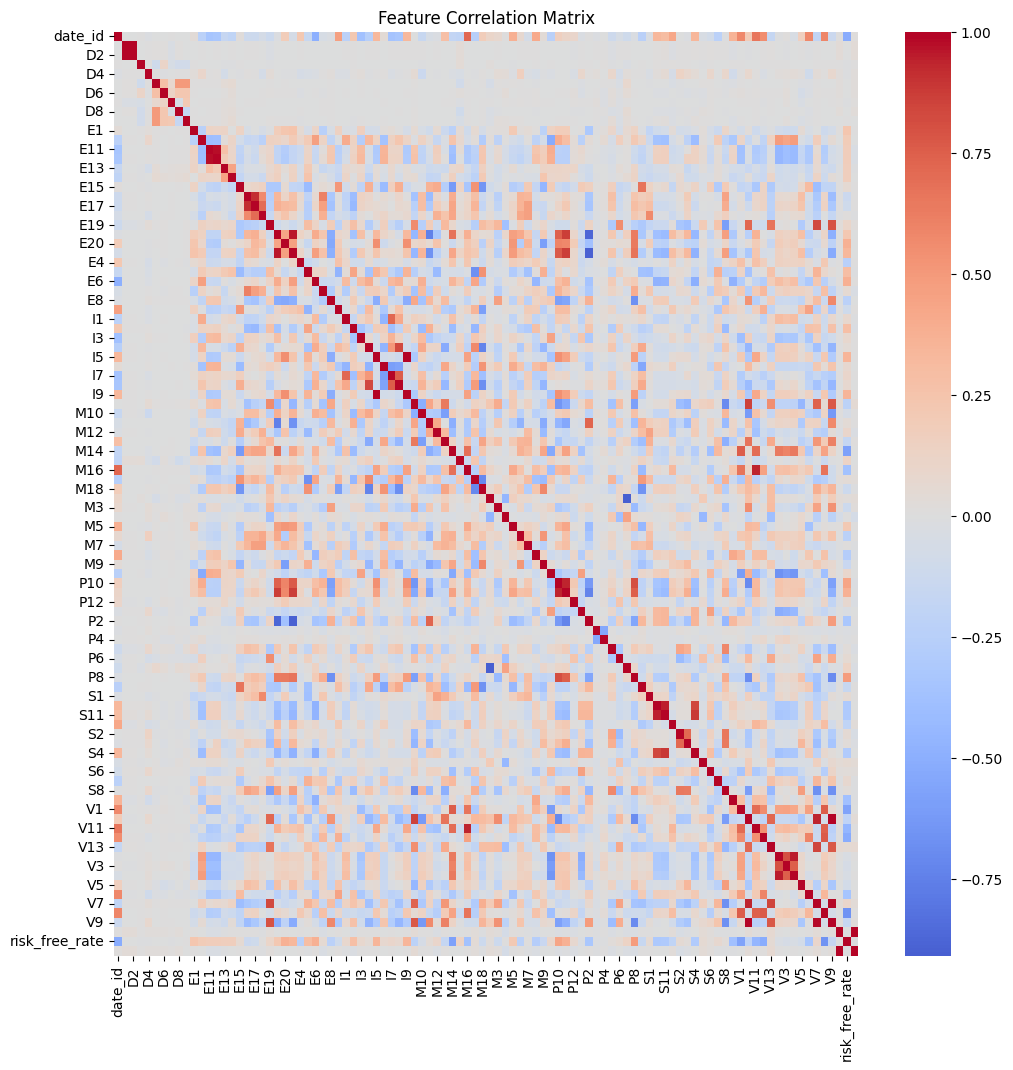

In [ ]:
corr = data.corr()

plt.figure(figsize=[12, 12])
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
if figs_dir: plt.savefig(os.path.join(figs_dir, "corr_matrix.png"))
plt.show()

There are few stronger correlations in the data, most of the variables do not correlate with the predicted variables or other variables strongly. 

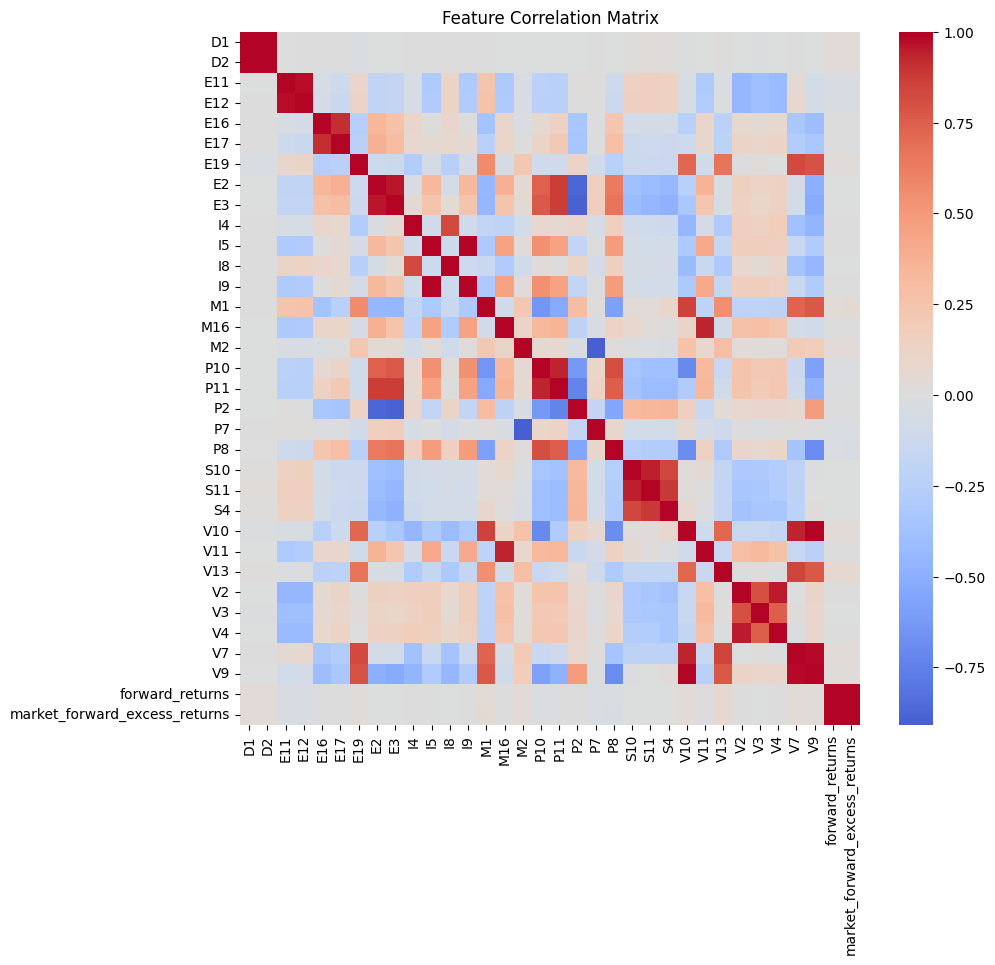

In [40]:
level = 0.8
idx = (np.max(np.abs(corr-np.eye(len(corr))), axis=0) > level).to_numpy()
strong_corr = corr.iloc[idx, idx]

plt.figure(figsize=(10, 9))
sns.heatmap(strong_corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
if figs_dir: plt.savefig(os.path.join(figs_dir, "strong_corr_matrix.png"))
plt.show()

---

## Time-series decomposition analysis

Based on the figure of the forward returns above, it seems that the time series to predict does not contain any long-term trend. The time series seems more like a heteroscedastic Gaussian stochastic process. Next we study whether the forward returns time series contain any short-term patterns.

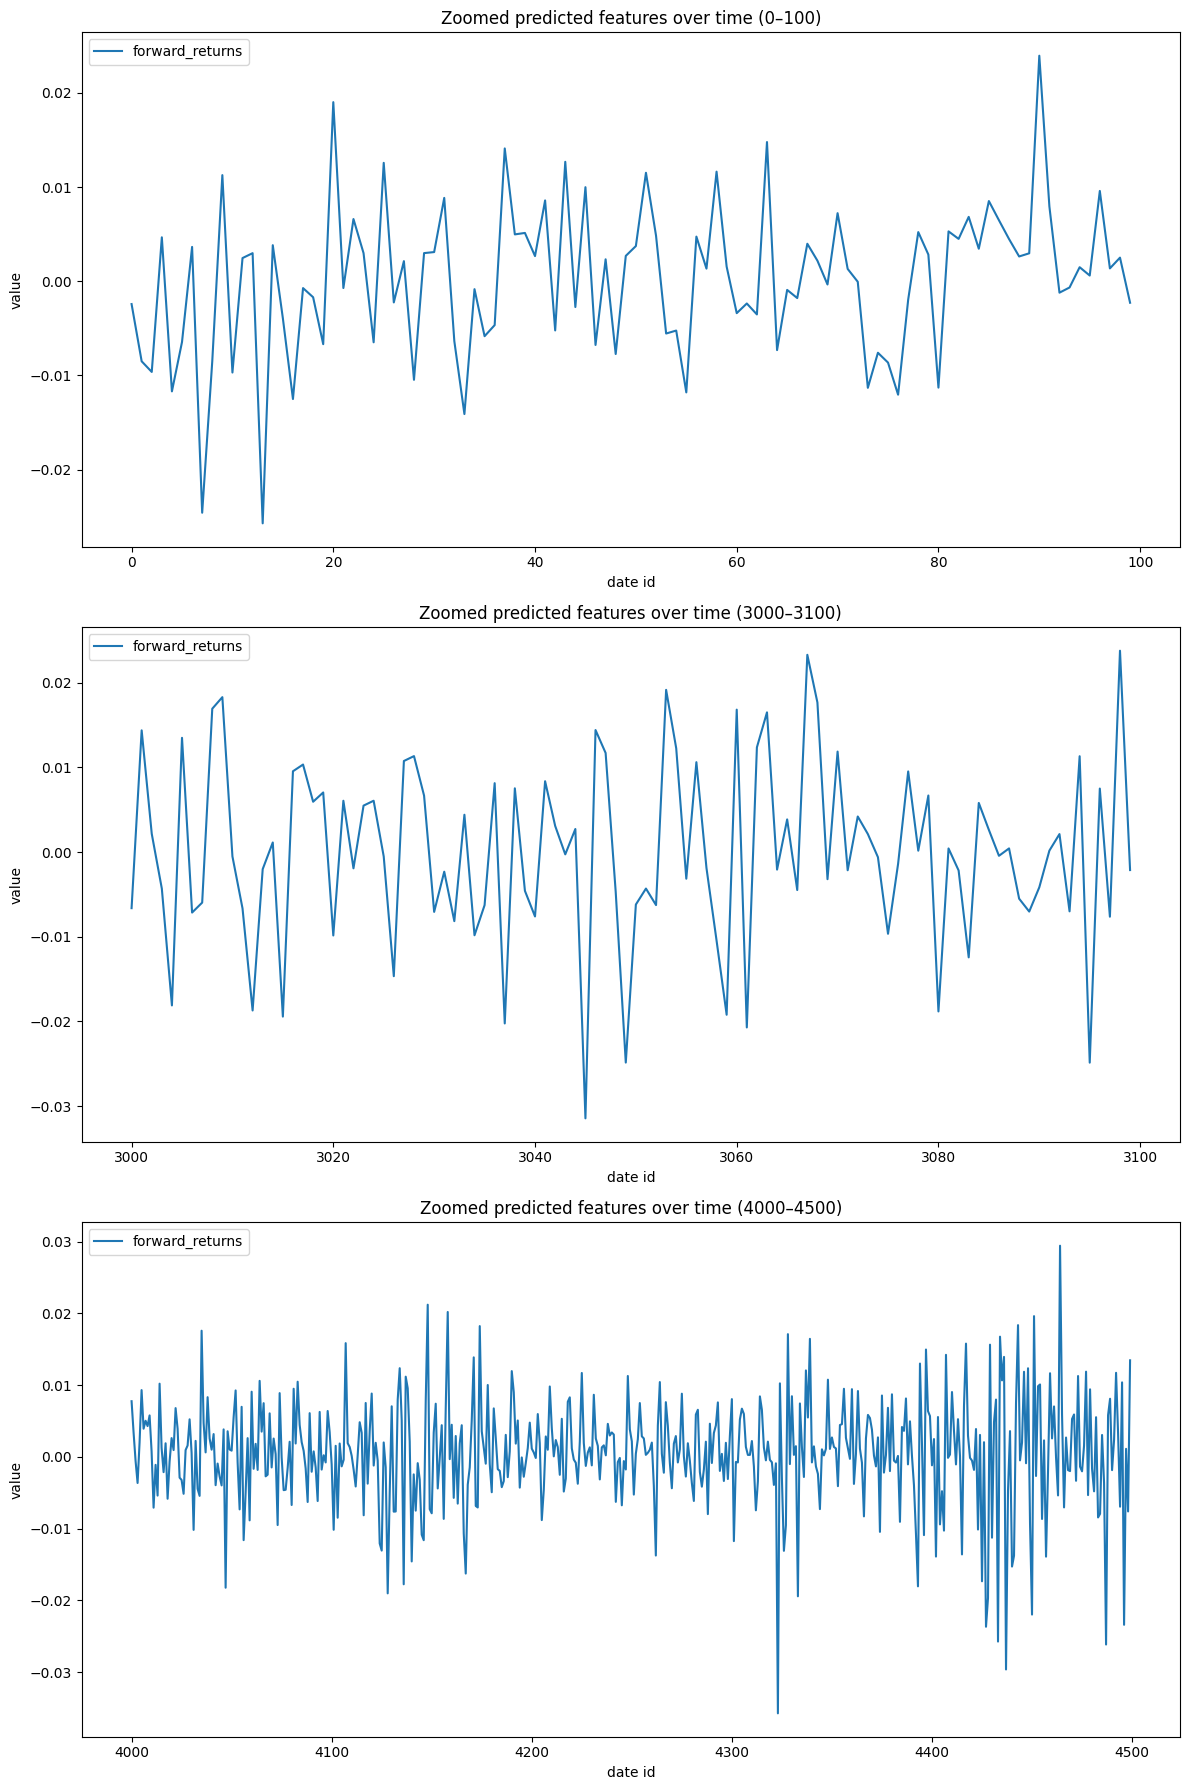

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

start_ind, end_ind = 0, 100
axes[0].plot(data['date_id'][start_ind:end_ind], data['forward_returns'][start_ind:end_ind], label='forward_returns')
axes[0].set_title('Zoomed predicted features over time (0–100)')
axes[0].legend(loc='upper left')
axes[0].set_xlabel("date id")
axes[0].set_ylabel("value")

start_ind, end_ind = 3000, 3100
axes[1].plot(data['date_id'][start_ind:end_ind], data['forward_returns'][start_ind:end_ind], label='forward_returns')
axes[1].set_title('Zoomed predicted features over time (3000–3100)')
axes[1].legend(loc='upper left')
axes[1].set_xlabel("date id")
axes[1].set_ylabel("value")

start_ind, end_ind = 4000, 4500
axes[2].plot(data['date_id'][start_ind:end_ind], data['forward_returns'][start_ind:end_ind], label='forward_returns')
axes[2].set_title('Zoomed predicted features over time (4000–4500)')
axes[2].legend(loc='upper left')
axes[2].set_xlabel("date id")
axes[2].set_ylabel("value")

# Adjust layout so titles/labels don’t overlap
plt.tight_layout()
plt.savefig("zoomed_forward_returns_plot.pdf")
plt.show()

It seems that the time series does not contain any clear long-term or short-term linear trend or seasonal pattern. Let's fit a linear regression to confirm that no linear trend exist.

In [34]:
len_ts = len(data['forward_returns'])
X = np.array([data['forward_returns'].index, np.ones(len_ts)]).T
y = np.array(data['forward_returns'].values).T
coefs = np.linalg.inv(X.T @ X) @ X.T @ y
print("Linear regression coefficients: ", coefs)

Linear regression coefficients:  [1.98082307e-08 3.82116136e-04]


/var/folders/vf/n0vzkjgd5pq00lx832rc0pf80000gn/T/ipykernel_55448/1867104890.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefs = np.linalg.inv(X.T @ X) @ X.T @ y
/var/folders/vf/n0vzkjgd5pq00lx832rc0pf80000gn/T/ipykernel_55448/1867104890.py:4: RuntimeWarning: overflow encountered in matmul
  coefs = np.linalg.inv(X.T @ X) @ X.T @ y
/var/folders/vf/n0vzkjgd5pq00lx832rc0pf80000gn/T/ipykernel_55448/1867104890.py:4: RuntimeWarning: invalid value encountered in matmul
  coefs = np.linalg.inv(X.T @ X) @ X.T @ y


Since the coefficients $\approx 0$ -> no long-term trend

As a conclusion, the time series to predict does not have any long-term trend or seasonal component.

---

## Autocorrelation analysis

---

## Partitioning the time-series data

In [ ]:
# Possible function to use for splitting
# from sklearn.model_selection import TimeSeriesSplit

## Plotting missing features

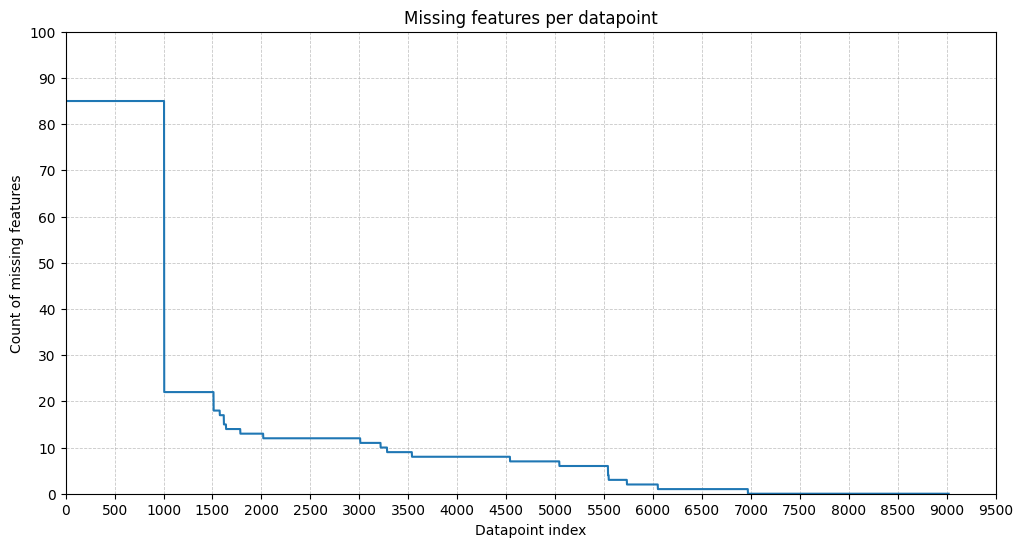

In [ ]:
# Searching for the missing values
# Count missing values per row
missing_per_row = data.isnull().sum(axis=1)

plt.figure(figsize=(12,6))
plt.plot(missing_per_row)
plt.title("Missing features per datapoint")
plt.xlabel("Datapoint index")
plt.ylabel("Count of missing features")
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
plt.xlim(0, 9500)
plt.ylim(0, 90)
plt.xticks(np.arange(0, 9501, 500))
plt.yticks(np.arange(0, 91, 10))
if figs_dir: plt.savefig(os.path.join(figs_dir, "missing_features_per_datapoint.png"))
plt.show()
